# ASSIGNMENT 1
---

**1) The k-nearest neighbor (k-NN) algorithm has hyper-parameters in addition to the value of k. Use the titanic dataset to simultaneously tune the values of more than one hyper-parameter. E.g. value of k, weight, and metric. You can either do nested for loops for this, or use the grid search function from scikit-learn.**

## Importing packages

In [27]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

Let's read some data into a dataframe!

In [28]:
df = pd.read_csv('Titanic_full.csv',index_col=0)
print(df.shape)
df.head(5)

(1309, 11)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Alright, looks like I've got 1309 rows across 11 columns considering that I have specified the first column of the dataframe to be treated as an index **(index_col = 0)**. Moving forward, let's take a holistic look at the data. 

Survived     0.00
Pclass       0.00
Name         0.00
Sex          0.00
Age         20.09
SibSp        0.00
Parch        0.00
Ticket       0.00
Fare         0.08
Cabin       77.46
Embarked     0.15
dtype: float64


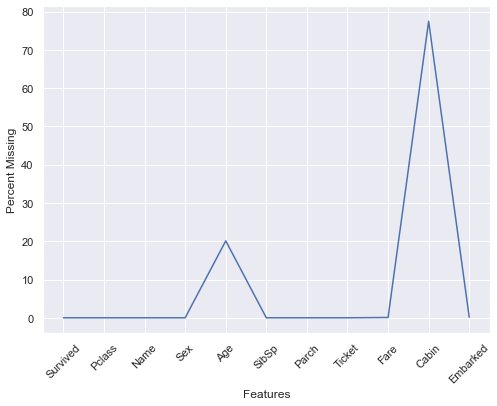

In [29]:
nulls = df.isnull().sum()/len(df)*100
nulls_pct = str(round(nulls,2))
print(nulls_pct)

plt.figure(figsize = (8,6))
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Percent Missing')
plt.plot(nulls)

There are a lot of nulls in the dataset that needs to be taken care of. In general practice, anything drastically over 25% is ideally discarded as it will affect the model prediction significantly. So, I drop column 'Cabin' which has almost 78% null values. 

In [30]:
df = df.drop('Cabin', axis=1)
print(df.shape)
df.head(5)

(1309, 10)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


## Data pre-preprocessing

I am going to preprocess this dataset as following:

1. Convert the entire dataframe to an array of numbers. This will be achieved in two ways: (a) Convert object types and string types to category type (b) map and convert cateogries of numbers.

2. Convert catagorical variables into numeric values.

3. Impute or "fill in" missing values or NaNs. Here, continuous (e.g. Fare column) and categorical values are treated separately. For filling up missing continuous values, we use the median value of that column, and filling up missing categorical values, we use the most frequent value present in the dataset.

4. Finally, for a lot of the algorithms like k-NN, we scale the data to lie between 0 and 1 with mean zero and unit variance.


**STEP (1): Converting string types into categories**

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 10 columns):
Survived    1309 non-null int64
Pclass      1309 non-null int64
Name        1309 non-null object
Sex         1309 non-null object
Age         1046 non-null float64
SibSp       1309 non-null int64
Parch       1309 non-null int64
Ticket      1309 non-null object
Fare        1308 non-null float64
Embarked    1307 non-null object
dtypes: float64(2), int64(4), object(4)
memory usage: 112.5+ KB


In [32]:
df.select_dtypes(['object']).columns

Index(['Name', 'Sex', 'Ticket', 'Embarked'], dtype='object')

Note that 4 columns are of the datatype Object which needs to be converted into categories. I am writing a lambda function that selects columns having dtype as 'Object' and converts it into category and that should serve our purpose.

In [33]:
df[df.select_dtypes(['object']).columns] = df.select_dtypes(['object']).apply(lambda x: x.astype('category'))    

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 10 columns):
Survived    1309 non-null int64
Pclass      1309 non-null int64
Name        1309 non-null category
Sex         1309 non-null category
Age         1046 non-null float64
SibSp       1309 non-null int64
Parch       1309 non-null int64
Ticket      1309 non-null category
Fare        1308 non-null float64
Embarked    1307 non-null category
dtypes: category(4), float64(2), int64(4)
memory usage: 176.9 KB


**STEP (2): Converting categorical variables into integer values**

In [35]:
print(df.Sex.cat.categories)
print(df.Embarked.cat.categories)


Index(['female', 'male'], dtype='object')
Index(['C', 'Q', 'S'], dtype='object')


Check the mappings of the 'Sex' & 'Embarked' categories. I am writing couple of functions that looks for the categorical values and returns an integer. Both these categories are written back to the original dataframe.

In [36]:
def gender_converter(gender):
    if gender=='male':
        return 1
    else:
        return 0
    
def embarked_converter(embarked):
    if embarked=='C':
        return 1
    elif embarked=='Q':
        return 2
    elif embarked=='S':
        return 3

In [37]:
df['Sex'] = df['Sex'].apply(gender_converter)
df['Embarked'] = df['Embarked'].apply(embarked_converter)

In [38]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,3
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,1
3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,3
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,3
5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,3


**STEP (3): Imputing missing values**

Previously, I eliminated a column with close to 78% nulls. Here, the percentage of missing values might be less but we cannot let them be. Instead, I will go ahead and impute those missing values with the help of some imputers. 

In [39]:
df.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         263
SibSp         0
Parch         0
Ticket        0
Fare          1
Embarked      2
dtype: int64

Now, Age & Fare both have float values in it, so I am going to take help of an **Imputer** function from scikit learn and make sure that the imputed values take median of that column. Again, instead of writing the imputed values separately and merging them to the dataframe later, I am choosing to write the result to the same column, wiping down the NaNs completely. 

As variable 'Embarked' is a category I have used a different imputer called **CatgoricalImputer** from sklearn_pandas which is a package that serves the gap between scikit learn and pandas libraries. **CatgoricalImputer** works with strings, substituting null values with the most frequent value in that column. Alternatively, you can specify a fixed value to use.

In [40]:
from sklearn.preprocessing import Imputer
from sklearn_pandas import CategoricalImputer #pip install sklearn-pandas

imp_median = Imputer(missing_values='NaN', strategy='median', axis=0)
imp_median.fit(df.iloc[:,[4,8]])

df[['Age','Fare']] = imp_median.fit_transform(df.iloc[:,[4,8]])

imp_freq = CategoricalImputer()
imp_freq.fit(df.iloc[:,9])

df['Embarked'] = imp_freq.fit_transform(df.iloc[:,9])

C:\Users\gaure\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [41]:
df.isnull().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    0
dtype: int64

In [42]:
df.head(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,3
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,1
3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,3
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,3
5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,3


There we have! All nulls are dealt with. 

**Step (3): Scaling**

The idea behind StandardScaler is that it will transform your data such that its distribution will have a mean value 0 and standard deviation of 1. Given the distribution of the data, each value in the dataset will have the sample mean value subtracted, and then divided by the standard deviation of the whole dataset.

In [43]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df[['Age','Fare']])
df[['Age','Fare']] = scaler.transform(df[['Age','Fare']])

In [44]:
df[['Age','Fare']].head(5)

,Age,Fare
PassengerId,,
1,-0.581628,-0.503291
2,0.658652,0.734744
3,-0.271558,-0.490240
4,0.426099,0.383183
5,0.426099,-0.487824


## Train test split

We plit the data into three sets in a 70-15-15 manner. This means 70% of the data rows go into building or training the model. 
This 70% is often called a training set. 15% of the data goes into evaluating model performance as you manually change or set the model hyperparameters (e.g. Value of K is a hyperparameter,in K-NN algorithm). This dataset is sometimes called a holdout set or the validation set. Finally, the last 15% of the data is the test set.  This dataset is never "seen" by the model for model building or hyperparamter tuning. After hyperparameter tuning and model selection, which we will discuss later, the model's final performance before sneidng it to production, will be evalauted on this test data set.

I achieved this with a two-step process
1. Split the source dataset into 70%(training)/30%(validation + test)
2. Split the 30%(validation + test) into 2 halves: 15%(validation)/15%(test)

In [146]:
from sklearn.model_selection import train_test_split

y = df['Survived']
X = df.drop(['Survived','Name','Ticket'], axis=1)

# 70% training and 30% validation + test
X_train, X_val_test, y_train, y_val_test = train_test_split(X,y,test_size=0.30)

# 15% validation and 15% test
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.50)

print("Training Set:", X_train.shape)
print("Validation Set:", X_val.shape)
print("Test Set:", X_test.shape)


Training Set: (916, 7)
Validation Set: (196, 7)
Test Set: (197, 7)


## Building Model and hyperparameter tuning

In [147]:
from sklearn.neighbors import KNeighborsClassifier

One of the essential components of KNN is the number of neighbors. It defines the size of the class, a given data point would be part of. Now I am going completely blind with the number of neighbors and choose 3 randomly. Let's see how the model fares!

In [148]:
knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train,y_train)
pred_val = knn.predict(X_val)

In [149]:
from sklearn.metrics import confusion_matrix, classification_report

Training set classification report:

               precision    recall  f1-score   support

           0       0.72      0.78      0.75       124
           1       0.56      0.49      0.52        72

    accuracy                           0.67       196
   macro avg       0.64      0.63      0.64       196
weighted avg       0.67      0.67      0.67       196



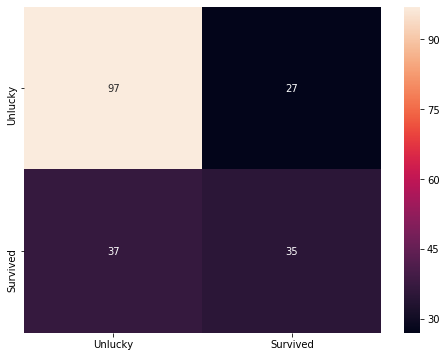

In [150]:
report = classification_report(y_val,pred_val)
print("Training set classification report:\n\n", report)

matrix = confusion_matrix(y_val,pred_val)

knn_train_matrix = pd.DataFrame(matrix)
plt.figure(figsize = (8,6))
sns.heatmap(matrix, xticklabels = ["Unlucky","Survived"], yticklabels = ["Unlucky","Survived"],annot = True)

In [151]:
from sklearn.metrics import confusion_matrix,accuracy_score,matthews_corrcoef,f1_score

print("Accuracy score:",np.round(accuracy_score(y_val,pred_val),2)) 
print("MCC:",np.round(matthews_corrcoef(y_val,pred_val),2))
print("f1 score:",np.round(f1_score(y_val,pred_val),2))

Accuracy score: 0.67
MCC: 0.28
f1 score: 0.52


Alright! I have accuracy at 67% which is not terrible but also open for improvement. One of best available options to look for the the appropriate parameters would be to do a Grid search. Scikit Learn's **GridSearchCV** lets you combine an estimator with a grid search preamble to tune hyper-parameters. The method picks the optimal parameter from the grid search and uses it with the estimator selected by the user. 

Here, my estimator would be a KNN Classifier and I am going to pass a list of neighbors (1 to 30) to Grid search and see what it returns. Additionally, we also want to see if tweaking other parameters like weight and metric could improve the accuracy. Default values of KNN parameters are, for **weight:uniform & metric:minkowski.** I am passing additional values to these parameters and see if it changes the accuracy at all. 

In [152]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

k_range = list(range(1, 31))

param_grid = {'n_neighbors':k_range, 'weights':['uniform','distance'], 'metric':['manhattan','euclidean']}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)

grid.fit(X_train, y_train)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    8.6s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid={'metric': ['manhattan', 'euclidean'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

In [153]:
print('Best Accuracy:',grid.best_score_)
print('------------------------------------------')
print('Best Parameters:\n',grid.best_params_)
print('------------------------------------------')
print('Best estimator:\n',grid.best_estimator_)

Best Accuracy: 0.6877729257641921
------------------------------------------
Best Parameters:
 {'metric': 'manhattan', 'n_neighbors': 27, 'weights': 'uniform'}
------------------------------------------
Best estimator:
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=27, p=2,
                     weights='uniform')


So now, we have an estimator that could give us the best accuracy possible on this dataset. Lets apply it on our training data. 

Also, instead of running our model again and again, I save it using the Joblib package into a directory. It not only saves time but also keeps the variables and structure of the model intact. 

In [154]:
from sklearn.externals import joblib

model = KNeighborsClassifier(n_neighbors = 27,weights = 'uniform', metric = 'manhattan')
model.fit(X_train,y_train)

!mkdir knn_model
knn_model_name = f'C:/Users/gaure/Desktop/INFO 6105 - Data Science Engineering Methods/knn_model/knn_model_final.sav'
joblib.dump(model,knn_model_name)

['C:/Users/gaure/Desktop/INFO 6105 - Data Science Engineering Methods/knn_model/knn_model_final.sav']

In [155]:
knn_model_test = joblib.load(knn_model_name)

## Testing the saved model on test set

In [156]:
pred_test = knn_model_test.predict(X_test)

In [157]:
print("Accuracy score:",np.round(accuracy_score(y_test,pred_test),2)) 
print("MCC:",np.round(matthews_corrcoef(y_test,pred_test),2))
print("f1 score:",np.round(f1_score(y_test,pred_test),2))

Accuracy score: 0.71
MCC: 0.33
f1 score: 0.54


Looks like running a gridsearch did help! Model accuracy has jumped from **67% to 71%**. Infact, Gridsearch predicted an accuracy surge of just about 2% (67% to 69%) but having our model work on a test set gave us 71% which is pretty good! 

That being said, thats all from me on KNN! 

**2) Can you use the k-nearest neighbors for regression? If so, how would the target variable values be calculated or predicted a k-NN regressor?**

1. Yes, K-nearest neighbors can be used as a regressor. Linear regressor assumes a linear relationship between predictor (X) and outcome (Y) and if the relationship is far from linear in reality, the model fits poorly to the data and any conclusions drawn from it is a suspect. On other hand, KNN does not assume a linear relationship and hence we have a flexible approach to work with. 


2. A simple implementation of KNN regression calculates the average of the numerical target of the k-nearest neighbors. It assumes a number of neigbors **K** and a prediction point **x**. Then, it identifies the training observations **n** closest to **x** and calculates the average of all responses in **n**


3. The optimal value for K will depend on the bias-variance tradeoff. A small value for K provides the most flexible fit, which will have low bias but high variance. This variance is due to the fact that the prediction in a given region is entirely dependent on just one observation. In contrast, larger values of K provide a smoother and less variable fit; the prediction in a region is an average of several points, and so changing one observation has a smaller effect.

**3) What do you think some of the disadvantages of k-NN algorithm are?**

i. _Does not work well with large datasets:_
K-NN functions by calculating distance between the existing point and a new data point. For this reason precisely, with large datasets, speed and efficiency of the algorithm decreases

ii. _Not suitable for high-dimensional data:_
K-NN does not work well with data having higher number of variables simply because it becomes difficult to calculate the distance in each dimension eventually struggling to predict the outcome. 

iii. _Needs scaled data:_ 
K-NN requires scaled (standardized & normalized) data to be feeded to the algorithm. Otherwise, K-NN might generate wrong predictions.

iv. _Choosing k-value:_
One of the biggest issues with K-NN is to choose the optimal value of neighbors while classifying the new data entry. More or less, this can be achieved over several iterations but selecting the right value can be tricky right on. 

v. _Imbalanced data:_
Consider two classes of data, A and B. If the majority of the data is labelled as A, the algorithm will wrongly classify the data points from class B as it will ultimately give a lot of preference to A.

vi. _Outliers and missing values:_ 
K-NN is sensitive to outliers and missing values. It requires manual imputing as it chooses neighbors only on basis of distance.